# 2. Análisis de audios como datos brutos

## Lectura de datos

Primero se definen las funciones necesarias para poder realizar la lectura de los archivos de audio

In [1]:
from scipy.io import wavfile

SAMPLE_RATE = 44100

def clean_filename(fname, string):
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':
        file_name = string + file_name
    return file_name


def load_wav_file(name, path):
    s, b = wavfile.read(path + name)
    assert s == SAMPLE_RATE
    return b

Luego, se lee el conjunto de datos disponible y se presenta la distribución de las clases a las que pertenece cada archivo. Se tiene que las clases se dividen en *Normal* y *Anormal*, y que ésta última se divide en la clases *Artifact*, *ExtraHLS* y *Murmur*.

artifact    40
murmur      34
normal      31
extrahls    19
Name: label, dtype: int64


count          124
unique           4
top       artifact
freq            40
Name: label, dtype: object


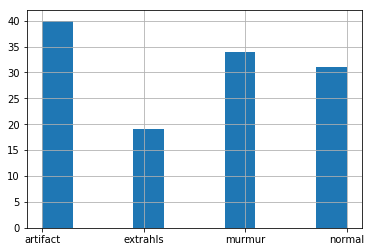

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('./heartbeat-sounds/set_a.csv')
print(df.label.value_counts())
print('\n')
print(df['label'].describe())
df['label'].hist()
plt.show()

Los archivos de audio se transforma a secuencias de tiempo para poder ser procesados.

In [3]:
def padd_zeros(array,length):
    aux = np.zeros(length)
    aux[:array.shape[0]] = array
    return aux
new_df = pd.DataFrame({'file_name' : df['fname'].apply(clean_filename,string='Aunlabelledtest')})
new_df['time_series'] = new_df['file_name'].apply(load_wav_file, path='./heartbeat-sounds/set_a/')


Podemos visualizar la estructura de las series de tiempo utilizando 4 archivos aleatorios del conjunto:

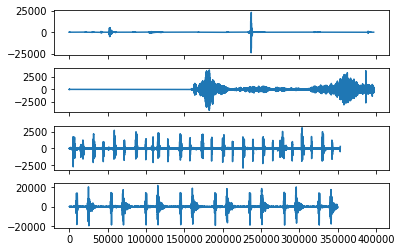

In [4]:
import matplotlib.pyplot as plt

def show_example_files(df, att):
    f, axarr = plt.subplots(4, sharex=True)
    axarr[0].plot(df[att][0])
    axarr[1].plot(df[att][10])
    axarr[2].plot(df[att][100])
    axarr[3].plot(df[att][70])
    f.subplots_adjust(hspace=0.3)
    plt.show()
    
show_example_files(new_df, 'time_series')

Se puede observar que los audios tienen distinto tamaño en el eje X debido a la duración que tiene cada uno. En efecto, se sabe que varias muestras pasaron por un proceso de reducción de duración con el objeto de eliminar posible ruido en las medicioens tomadas en los dispositivos móviles.

Por lo anterior, es necesario añadir ceros a las series de tiempo con el fin de normalizar el largo de todos los inputs.

In [5]:
new_df['len_series'] = new_df['time_series'].apply(len)
new_df['time_series'] = new_df['time_series'].apply(padd_zeros,length=max(new_df['len_series']))

Los archivos analizados anteriormente quedan entonces de la siguiente manera:

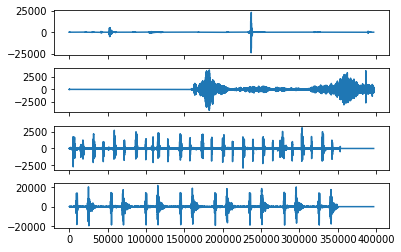

In [6]:
show_example_files(new_df, 'time_series')

## Modificación de labels

Según Peter Grenholm, un doctor experto en el área, los latidos extra del corazón son demasiado raros como para aportar en evaluaciones medicas y en toma de decisiones en general, esto al menos en el ámbito de las cirugías cardiacas. My experience from med school is that extra heart sounds don't really exist any more - at least not outside of cardiac surgery. Aún cuando se hacen presentes, la importancia de los otros fenómenos en los latidos son muchísimo más importantes al nivel de serlo en ordenes de magnitud.

Por lo mismo, este doctor ha propuesto la concatenación de aquellos latidos que son de tipo "extra hls" con los atributos normales, eliminando la clasificación de "extra hls" por completo.

Realizando la modificación, se tiene la siguiente nueva distribución de los datos:

normal/extrahls    65
artifact           58
murmur             53
Name: target, dtype: int64


count                 176
unique                  3
top       normal/extrahls
freq                   65
Name: target, dtype: object


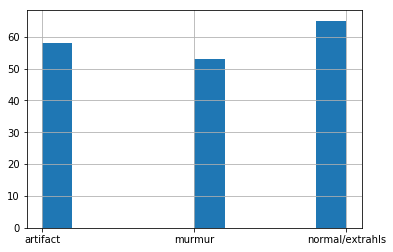

In [7]:
import matplotlib.pyplot as plt
new_labels=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,1,1,1,1,1,
    1,1,1,1,1,2,1,1,1,2,2,2,1,1,2,1,2,2,1,2,2,2,2,2,2,
    2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,
    1,2,1,1,1,1,1,2,1,1,1,1,1,1,1,2,2,1,1,1,1,1,2,1,0,
    2,2,1,1,1,1,1,0,1,0,1,1,1,2,1,0,1,1,1,1,1,2,0,0,0,
    0,0,0,0,1,0,0,0,0,0,0,1,0,2,1,2,2,2,2,2,2,2,2,2,2, 2]
labels = ['artifact','normal/extrahls', 'murmur']
new_df['target'] = [labels[i] for i in new_labels]

print(new_df.target.value_counts())
print('\n')
print(new_df['target'].describe())
new_df['target'].hist()
plt.show()

Tener etiquetas incorrectas en el conjunto de datos llevará al modelo a aprender acerca de estos comportamientos. Esto se debe a que todos los modelos de aprendizaje asumen los datos de entrada como verdades absolutas, por lo que es de suma importancia tener datos de entrenamiento correctamente clasificados y con sus atributos correctamente medidos.

La inclusión de múltiples datos erróneos puede afectar gravemente el poder predictivo y de generalización de una máquina de aprendizaje utilizando cualquier modelo. Sin embargo, si se tienen instancias aisladas (un solo dato, por ejemplo), el efecto no será significativo debido a que este dato outlier se hace irrelevante ante la fuerza del resto del conjunto de datos

## Procesamiento de datos

Para realizar el procesamiento de los datos, es necesario codificar los labels a valores numéricos para que pudan ser usados por algoritmos clasificadores. Se tiene entonces:

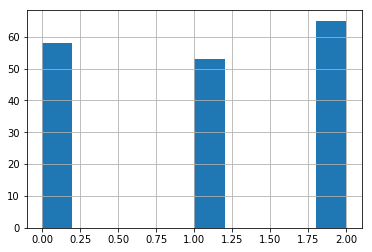

In [8]:
import matplotlib.pyplot as plt
new_df["target"] = new_df["target"].astype('category')
cat_columns = new_df.select_dtypes(['category']).columns
new_df[cat_columns] = new_df[cat_columns].apply(lambda x: x.cat.codes)
new_df.target.value_counts()
new_df['target'].hist()
plt.show()

Es necesario desordenar o reordenar de manera aleatoria los datos de entrada para evitar que el orden influya en el aprendizaje de los algoritmos de clasificación.

Incluso si se menciona de antemano en un conjunto de datos que existe aletoriedad, es mejor volver a aplicar algún grado de aleatoriedad con el fin de asegurarnos de que estamos trabajando con muestreos representativos a los cuales el orden no afectará, especialmente con algunos modelos como K-neighboors en dónde el orden si importa para casos bordes que no son tan infrecuentes.

A continuación se procede a realizar dicho reorden aleatorio y a generar la matriz de los datos, en donde cada unidad de tiempo actuará como un atributo de cada input x correspondiente a un archivo (dicho de otro modo, los atributos de nuestro input son N, dónde N es la cantidad de unidades de tiempo totales de cada archivo).

In [9]:
new_df = new_df.sample(frac=1,random_state=44)
X = np.stack(new_df['time_series'].values, axis=0)
y = new_df.target.values
X.shape

(176, 396900)

Se puede observar que se tiene un total de $p = 176$ datos con una dimensionalidad de $N = 396900$. Esto implica que la dimensionalidad del modelo es al menos 3 ordenes de magnitud mayor que la cantidad de atributos, lo que reducirá la capacidad de generalización de los modelos de clasificación debido a la maldición de la dimensionalidad.

Una técnica para poder suavizar este problema, consiste realizar un muestreo de los atributos originales de cada muestra en nuestro conjunto de datos con el propósito de reducir la dimensionalidad. El remuestreo considerará intervalos de tiempo mayores que los originales, por lo que se debe elegir con sumo cuidado para no perder información.

A continuación, se aplica una transformada de fourier para poder manipular los datos:

In [10]:
X_fourier = np.abs(np.fft.fft(X))

G) Para seguir con el pre procesamiento realice un muestreo representativo de los datos a trav ́es de una t ́ecnica de muestreo especializada en secuencias ¿En qu ́e beneficia este paso? ¿C ́omo podr ́ıa determinar si el muestro es representativo?

Luego, se realiza el remuestro para reducir la cantidad de tiempos

In [11]:
from scipy import signal
X_resampled = []
for i in range(X_fourier.shape[0]):
    sequence = X_fourier[i,:].copy()
    resampled_sequence = signal.resample(sequence, 100000)
    X_resampled.append(resampled_sequence)
X_resampled = np.array(X_resampled)
X_resampled.shape

(176, 100000)

Se puede asegurar que el muestreo es representativo de la población considerando que se mantiene la misma distribución de los datos original y no se produce un remuestreo del conjunto de audios de entrada (esto es, no se reduce el número de audios original). Además, el proceso de interpolación que se realiza en sus atributos es comparablemente similarmente en ordenes de magnitud.

## Conjunto de validación

Se genera un conjunto de validación utilizando la técnica hold out validation (utilizar un porcentaje de los datos para validación). En este caso, el conjunto de validación es de 25% de los datos originales

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_test.shape)

(132, 100000)
(44, 100000)


En donde se tiene que el conjunto de entrenamiento tiene 132 entradas de audio y el de validación de 44

## Estandarización y dimensionalidad

Para poder trabajar los datos adecuadamente, se debe realizar un proceso de estandarización para tener todos los atributos en un rango de $[0, 1]$ con el objeto de optimizar el proceso de aprendizaje

In [13]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

A continuación, se realiza un proceso de reducción de dimensionalidad con el objetivo de optimizar el proceso de aprendizaje de los distintos modelos a utilizar. Inicialmente, se reduce la dimensión a $d = 2$

J) Realice una reducci ́on de dimensionalidad a trav ́es de la t ́ecnica PCA, para representar los datos en d = 2 dimensiones. Recuerde que solo se debe ajustar (encontrar las componentes principales) con el conjunto de entrenamiento. Visualice apropiadamente la proyecci ́on en 2 dimensiones.

In [14]:
from sklearn.decomposition import PCA
d=2
pca_model = PCA(n_components=d)
pca_model.fit(X_train)
X_pca_train = pca_model.transform(X_train)
X_pca_test = pca_model.transform(X_test)

La proyección realizada por PCA se puede visualizar en el siguiente gráfico:

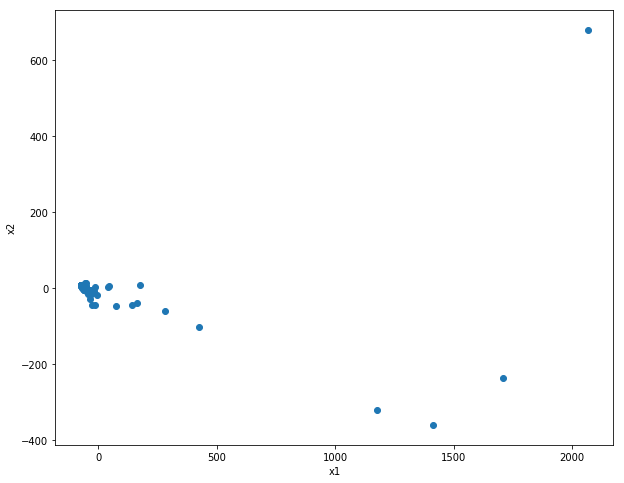

In [15]:
x1 = np.array(X_pca_train)[:,0]
x2 = np.array(X_pca_train)[:,1]
plt.figure(figsize=(10, 8))
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(x1, x2)
plt.show()

## Entrenamiento con PCA

A continuación se procederá a entrenar distintos modelos de clasificación, utilizando distintos valores para los hiperparámetros correspondientes a cada uno. Estos modelos corresponden a **Regresión Logística**, **SVM lineal**, **Árboles de decisión**

Los rangos de los hiperparámetros de definen a continuación en donde $C_s$ maneja el hiperparámetro de regresión logística y SVM lineal, mientras que $Depths$ maneja la profundidad del árbol

In [16]:
Cs = [0.0001,0.01,0.1,1,10,100,1000]
Depths = range(1,30)

#### Regresión logistica

In [17]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_logistic(Xtrain, ytrain, Xtest, ytest, C):
    train_error = []
    test_error = []
    for c in C:
        model = LR()
        model.set_params(C=c, penalty='l2')
        model.fit(Xtrain, ytrain)
        ypredict = model.predict(Xtrain)
        train_error.append(1-accuracy_score(ytrain, ypredict))
        ypredict = model.predict(Xtest)
        test_error.append(1-accuracy_score(ytest, ypredict))
    return train_error, test_error
        
logistic_train_errors, logistic_test_errors = train_logistic(X_pca_train, y_train, X_pca_test, y_test, Cs)

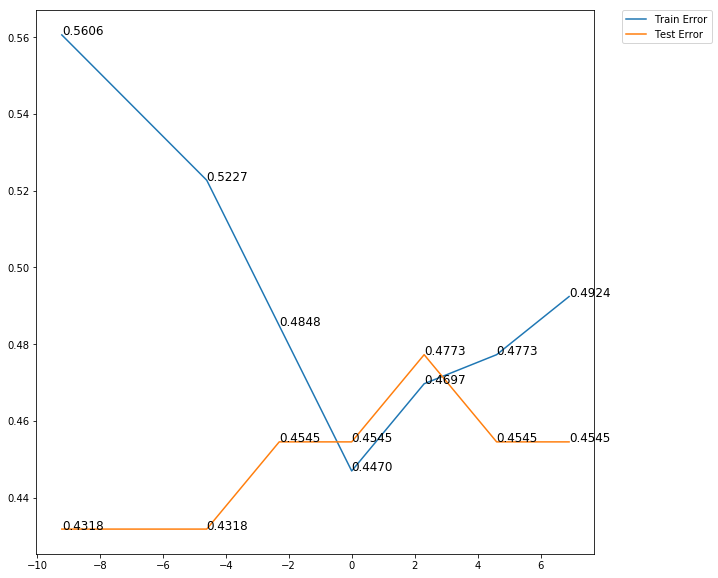

Mínimo error de entrenamiento:  0.44696969697
Mínimo error de testing 0.431818181818


In [18]:

def plot_logistic(train_errors, test_errors, fig=None, verbose=True):
    
    if (fig is not None):
        fig.plot(np.log(Cs), train_errors, label="Train Error")
        fig.plot(np.log(Cs), test_errors, label="Test Error")
        fig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        for i in range(0, len(train_errors)):
            fig.annotate("%.2f" % train_errors[i], (np.log(Cs)[i], train_errors[i]), fontsize=12)
            
        for i in range(0, len(train_errors)):
            fig.annotate("%.2f" % test_errors[i], (np.log(Cs)[i], test_errors[i]), fontsize=12)
    else:
        plt.figure(figsize=(10, 10))
        plt.plot(np.log(Cs), train_errors, label="Train Error")
        plt.plot(np.log(Cs), test_errors, label="Test Error")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        for i in range(0, len(train_errors)):
            plt.annotate("%.4f" % train_errors[i], (np.log(Cs)[i], train_errors[i]), fontsize=12)
            
        for i in range(0, len(train_errors)):
            plt.annotate("%.4f" % test_errors[i], (np.log(Cs)[i], test_errors[i]), fontsize=12)
        plt.show()
    if (verbose):
        print('Mínimo error de entrenamiento: ', np.min(train_errors))
        print('Mínimo error de testing', np.min(test_errors))
    
plot_logistic(logistic_train_errors, logistic_test_errors)

#### SVM

In [19]:
from sklearn.svm import SVC as SVM #SVC is for classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_svm(Xtrain, ytrain, Xtest, ytest, C):
    train_error = []
    test_error = []
    for c in C:
        model= SVM()
        model.set_params(C=c,kernel='linear')
        model.fit(Xtrain, ytrain)
        ypredict = model.predict(Xtrain)
        train_error.append(1-accuracy_score(ytrain, ypredict))
        ypredict = model.predict(Xtest)
        test_error.append(1-accuracy_score(ytest, ypredict))
    return train_error, test_error
        
svm_train_errors, svm_test_errors = train_svm(X_pca_train, y_train, X_pca_test, y_test, Cs)

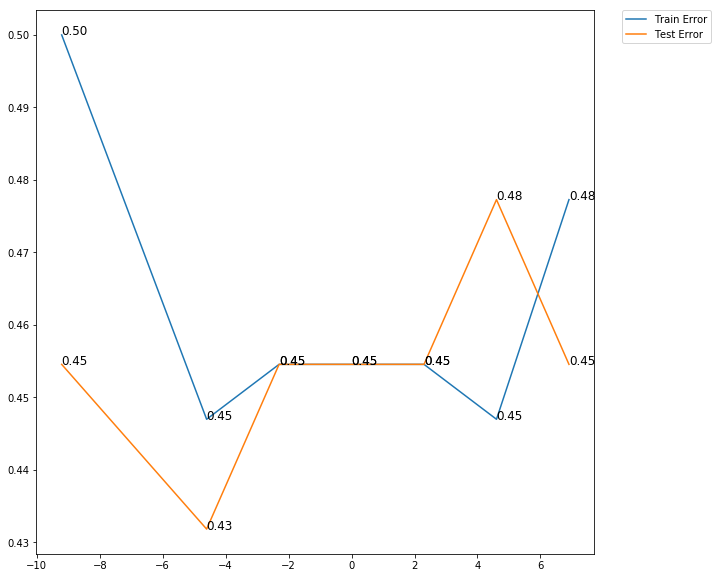

Mínimo error de entrenamiento:  0.44696969697
Mínimo error de testing 0.431818181818


In [20]:
def plot_svm(train_errors, test_errors, fig=None, verbose=True):
    if (fig is not None):
        fig.plot(np.log(Cs), train_errors, label="Train Error")
        fig.plot(np.log(Cs), test_errors, label="Test Error")
        fig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        for i in range(0, len(train_errors)):
            fig.annotate("%.2f" % train_errors[i], (np.log(Cs)[i], train_errors[i]), fontsize=12)
            
        for i in range(0, len(train_errors)):
            fig.annotate("%.2f" % test_errors[i], (np.log(Cs)[i], test_errors[i]), fontsize=12)
    else:
        plt.figure(figsize=(10, 10))
        plt.plot(np.log(Cs), train_errors, label="Train Error")
        plt.plot(np.log(Cs), test_errors, label="Test Error")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        for i in range(0, len(train_errors)):
            plt.annotate("%.2f" % train_errors[i], (np.log(Cs)[i], train_errors[i]), fontsize=12)
            
        for i in range(0, len(train_errors)):
            plt.annotate("%.2f" % test_errors[i], (np.log(Cs)[i], test_errors[i]), fontsize=12)
        plt.show()
    if (verbose):
        print('Mínimo error de entrenamiento: ', np.min(train_errors))
        print('Mínimo error de testing', np.min(test_errors))
plot_svm(svm_train_errors, svm_test_errors)

#### Árboles de decisión

In [21]:
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_tree(Xtrain, ytrain, Xtest, ytest, depths):
    train_error = []
    test_error = []
    for depth in depths:
        model = Tree() #edit the train_model function
        model.set_params(max_depth=depth,criterion='gini',splitter='best')
        model.fit(Xtrain, ytrain)
        ypredict = model.predict(Xtrain)
        train_error.append(1-accuracy_score(ytrain, ypredict))
        ypredict = model.predict(Xtest)
        test_error.append(1-accuracy_score(ytest, ypredict))
    return train_error, test_error
        
tree_train_errors, tree_test_errors = train_tree(X_pca_train, y_train, X_pca_test, y_test, Depths)

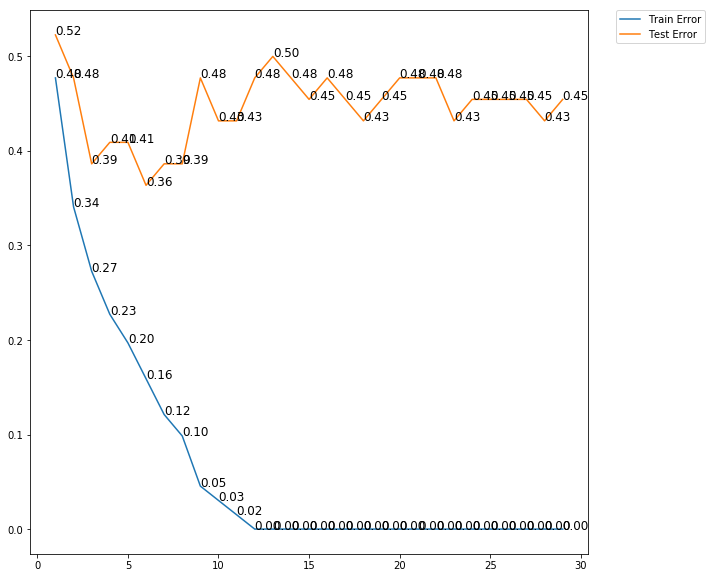

Mínimo error de entrenamiento:  0.0
Mínimo error de testing 0.363636363636


In [22]:
def plot_tree(train_errors, test_errors, fig=None, verbose=True):
    if (fig is not None):
        fig.plot(Depths, train_errors, label="Train Error")
        fig.plot(Depths, test_errors, label="Test Error")
        fig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        for i in range(0, len(train_errors)):
            fig.annotate("%.2f" % train_errors[i], (Depths[i], train_errors[i]), fontsize=12)
            
        for i in range(0, len(train_errors)):
            fig.annotate("%.2f" % test_errors[i], (Depths[i], test_errors[i]), fontsize=12)
    else:
        plt.figure(figsize=(10, 10))
        plt.plot(Depths, train_errors, label="Train Error")
        plt.plot(Depths, test_errors, label="Test Error")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        for i in range(0, len(train_errors)):
            plt.annotate("%.2f" % train_errors[i], (Depths[i], train_errors[i]), fontsize=12)
            
        for i in range(0, len(train_errors)):
            plt.annotate("%.2f" % test_errors[i], (Depths[i], test_errors[i]), fontsize=12)
        plt.show()
    if(verbose):
        print('Mínimo error de entrenamiento: ', np.min(tree_train_errors))
        print('Mínimo error de testing', np.min(tree_test_errors))
plot_tree(tree_train_errors, tree_test_errors)

#### Comparación entre modelos

##### Regresión v/s SVM lineal

Regresión logística y SVM lineal siguen un comportamiento similar en dónde con valores pequeños de $Cs$ se presental el fenómeno de underfitting en donde el error de entrenamiento es mayor al error de testing. Esto esperable debido a que parámetros $C$ pequeños implican una alta concentración del algoritmo por maximizar el margen de las fronteras de clasificación sin considerar a los atributos de los conjuntos. Por otro lado y para valores grandes de C se manifiesta el fenómeno de overfitting en donde el error de entrnamiento mejora relativamente y el de testing empeora.

Considerando el mínimo error de entrnamiento, se tiene que ambos modelos tienen el mismo rendimiento por lo que la selección vendría dada solamente por aquel que esté mejor optimizado y presente los mejores tiempos de ejecución.

###### Árbol de decisión v/s modelos lineales

Comparando los distintos modelos utilizados, podemos notar que el modelo de árbol de decisión es el que presenta el menor error de clasificación en el conjunto de testing. Se puede apreciar que el fenómeno de overfitting se presenta rápidamente con profundidad igual a 12. Aún así, el valor entregado por el árbol se manifiesta en valores de profundidad con error de entrenamiento razonable en dónde no existe overfitting.

Dado lo anterior, el mejor modelo en este caso es el árbol de decisión

## Dimensionalidad de PCA

Para obtener menor error de testing, se utilizará **PCA** con distintos valores de dimensionalidad, usando los distintos modelos estudiados anteriormente. Se utilizarán los siguientes valores de dimensionalidad:

In [23]:
dims = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

De los cuales se obtienen los siguientes resultados para cada modelo

In [24]:
def get_results_for_pca_dimensionality(d):
    pca_model = PCA(n_components=d)
    pca_model.fit(X_train)
    X_pca_train = pca_model.transform(X_train)
    X_pca_test = pca_model.transform(X_test)
    f, [ax1, ax2, ax3] = plt.subplots(3)
    f.suptitle('Dimensionalidad %d' % d, fontsize=20)
    f.set_size_inches(16, 8)

    (train, test) = train_logistic(X_pca_train, y_train, X_pca_test, y_test, Cs)
    plot_logistic(train, test, fig=ax1, verbose=False)
    log_min_error = np.amin(test)

    (train, test) = train_svm(X_pca_train, y_train, X_pca_test, y_test, Cs)
    plot_svm(train, test, fig=ax2, verbose=False)
    svm_min_error = np.amin(test)

    (train, test) = train_tree(X_pca_train, y_train, X_pca_test, y_test, Depths)
    plot_tree(train, test, fig=ax3, verbose=False)
    tree_min_error = np.amin(test)
    plt.show()
    return (log_min_error, svm_min_error, tree_min_error)

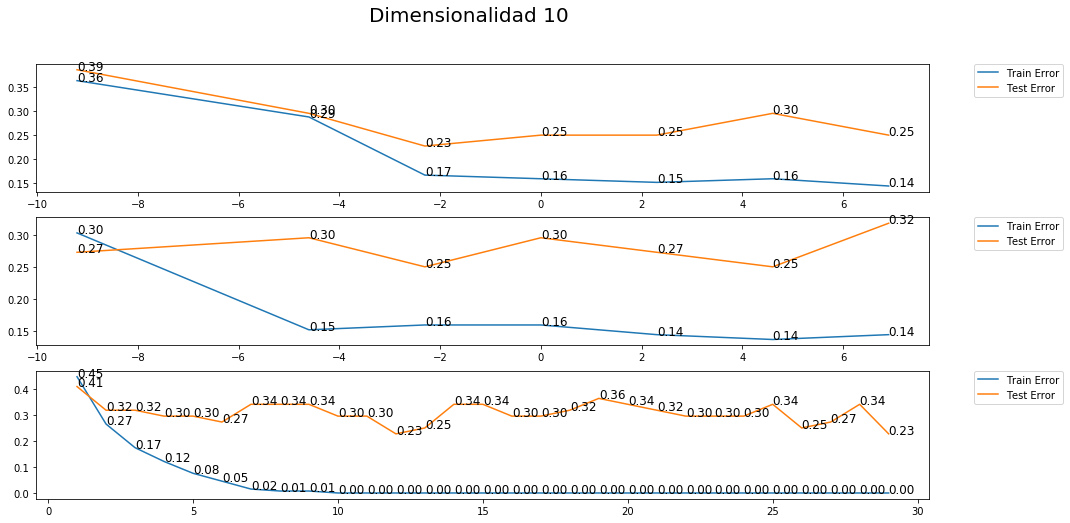

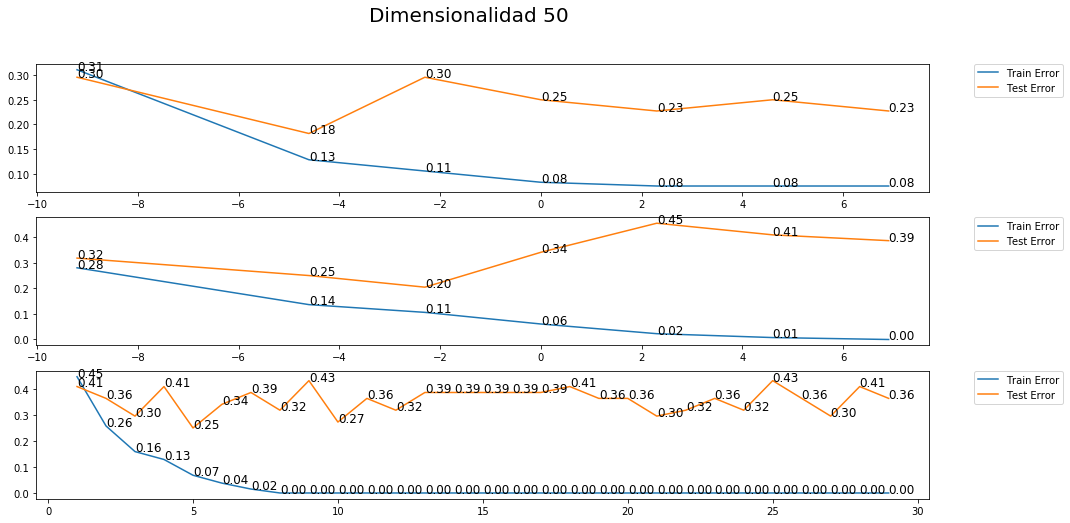

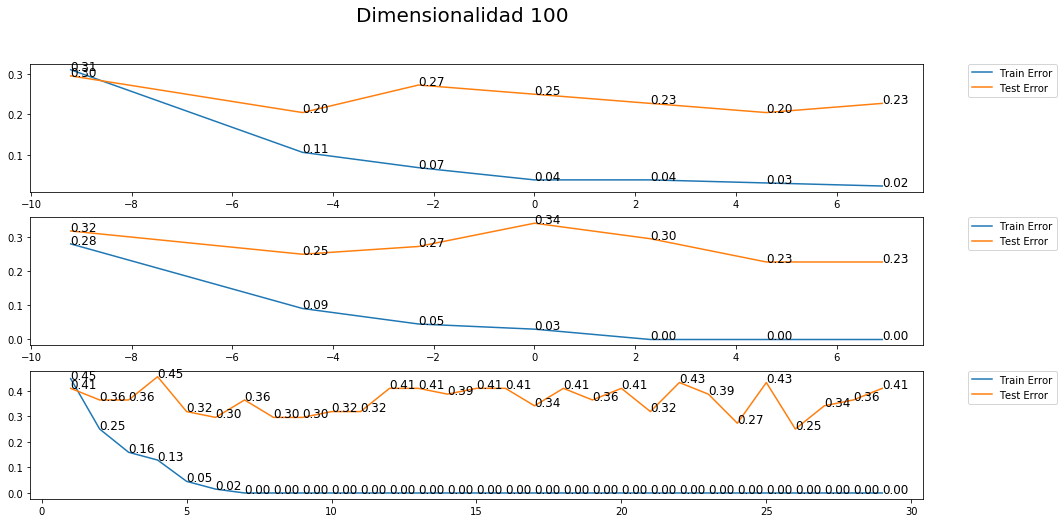

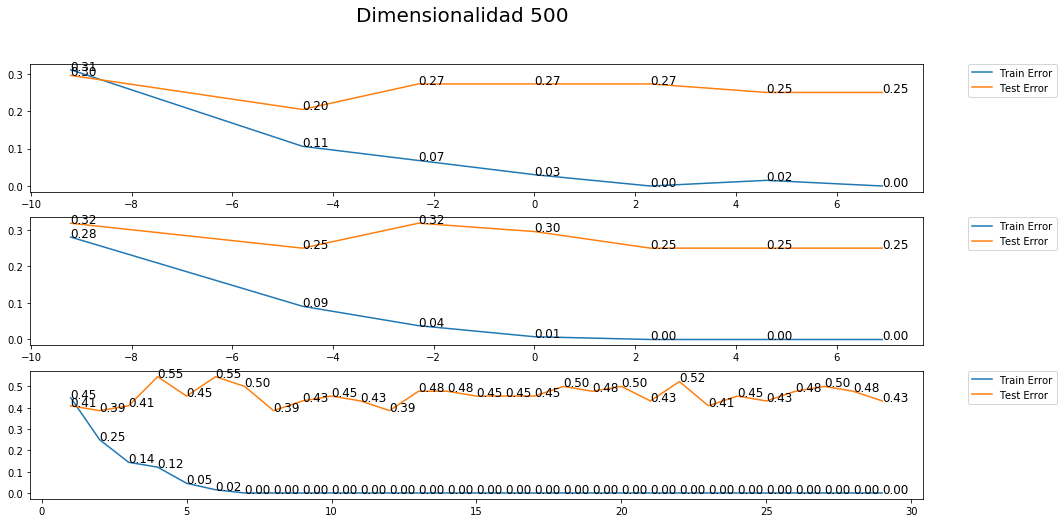

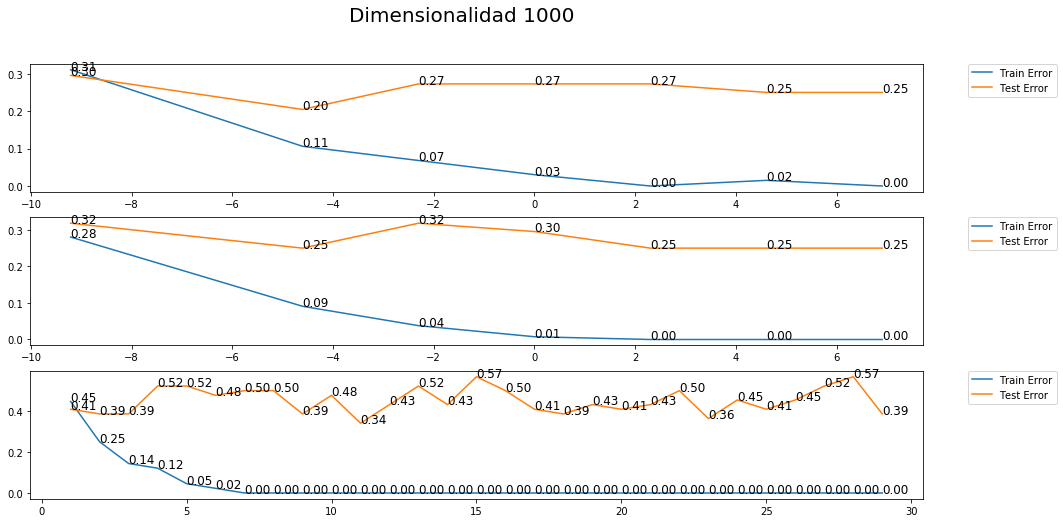

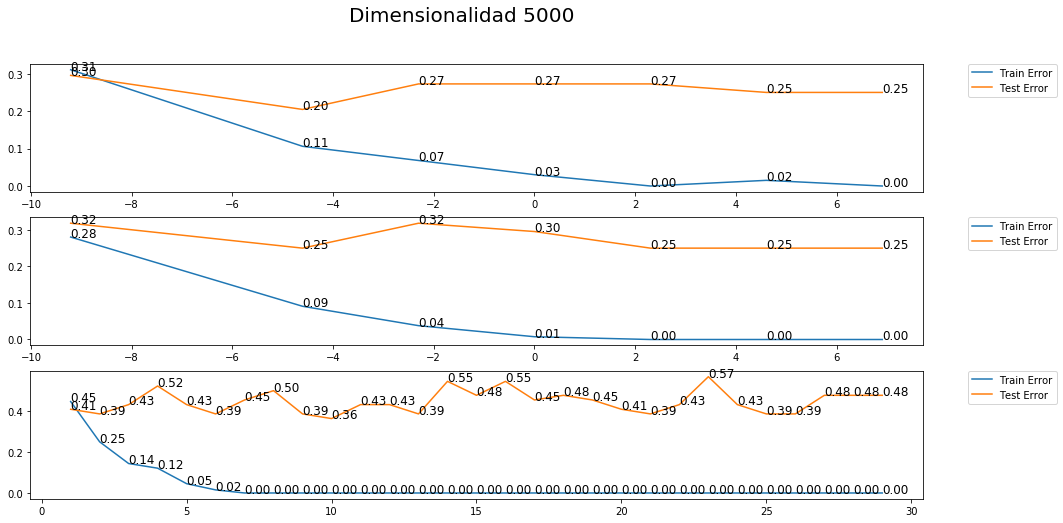

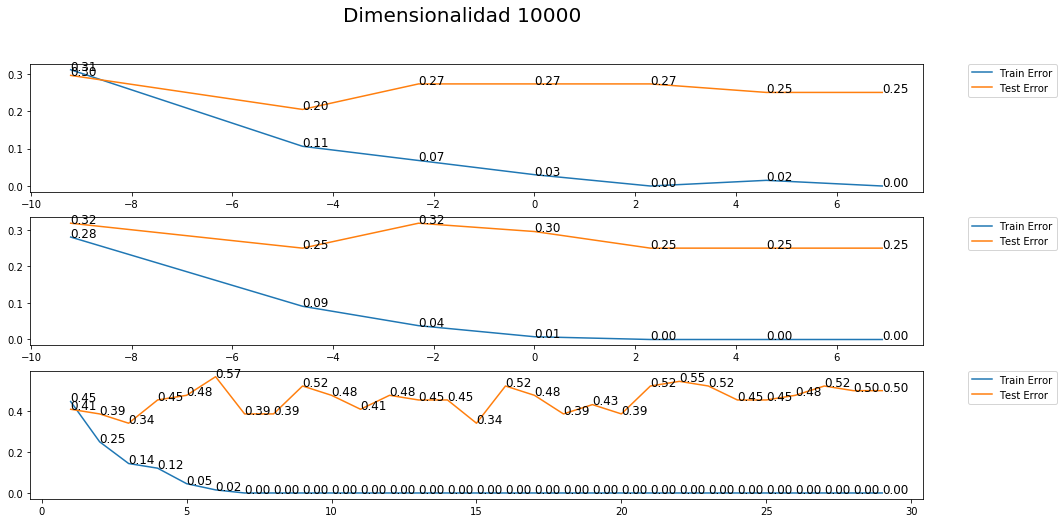

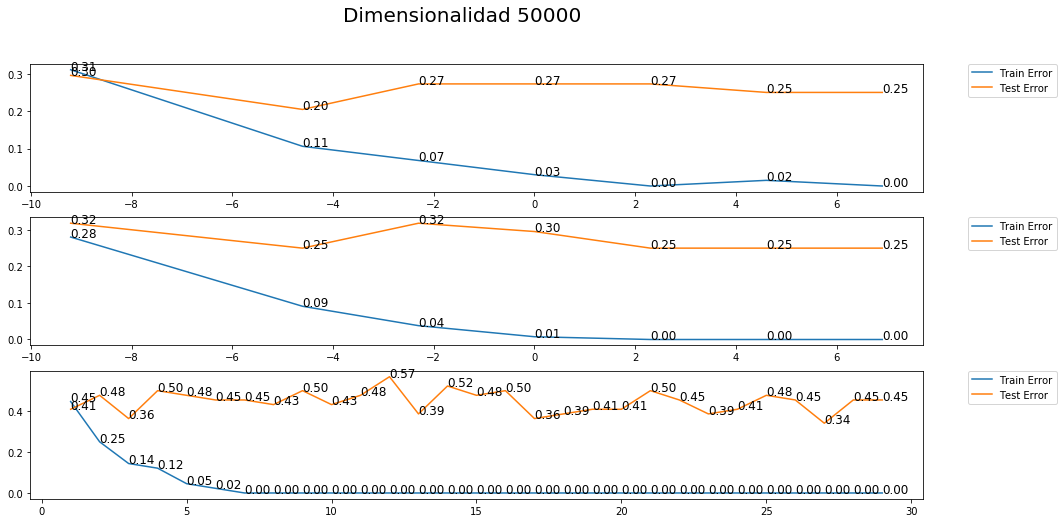

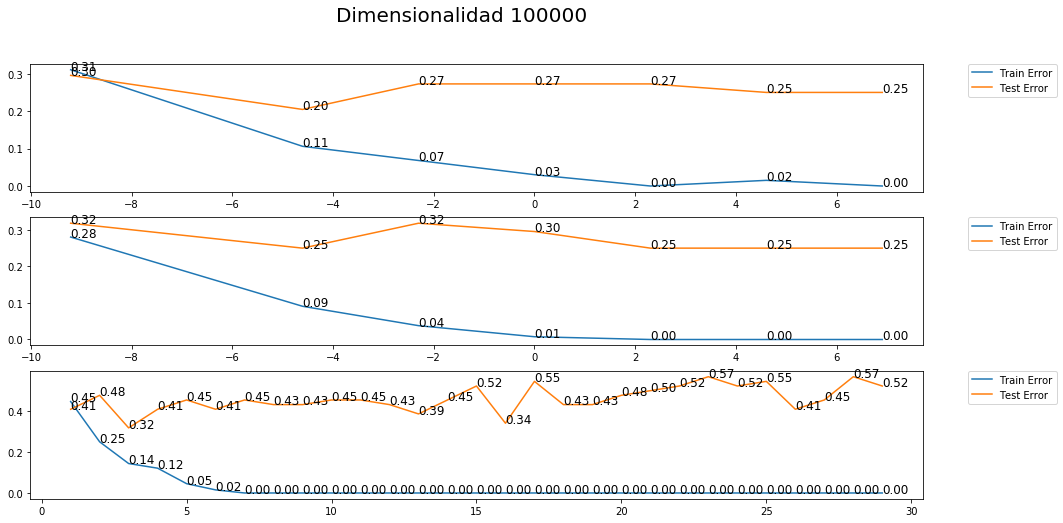

In [25]:
pca_log_min_test_error = []
pca_svm_min_test_error = []
pca_tree_min_test_error = []
for d in dims:
    (log_min, svm_min, tree_min) = get_results_for_pca_dimensionality(d)
    pca_log_min_test_error.append(log_min)
    pca_svm_min_test_error.append(svm_min)
    pca_tree_min_test_error.append(tree_min)

Analizando el error mínimo para cada modelos se tiene el siguiente gráfico:

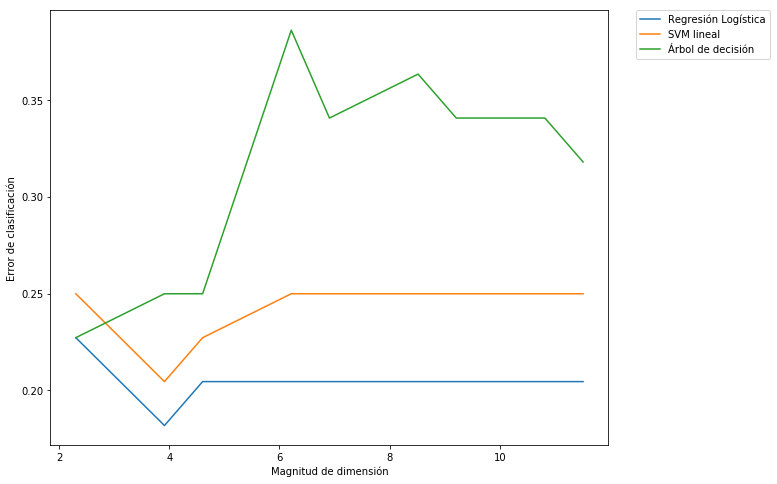

In [26]:
plt.figure(figsize=(10, 8))
plt.plot(np.log(dims), pca_log_min_test_error, label="Regresión Logística")
plt.plot(np.log(dims), pca_svm_min_test_error, label="SVM lineal")
plt.plot(np.log(dims), pca_tree_min_test_error, label="Árbol de decisión")

plt.xlabel('Magnitud de dimensión')
plt.ylabel('Error de clasificación')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Se puede notar que a medida que aumenta la magnitud de la dimensión del conjunto de datos, el árbol de decisión inicialmente utilizado empeora su desempeño en comparación a los algoritmos lineales. Esto se puede explicar debido a que el árbol de decisión debe basar su decisión entre demasaidos atributos, por lo que necesitarñia de un gran número de profundidad para mejorar sus valores.

Lo anterior podría llegar a ser muy costoso por lo que es mejor utilizar los modelos lineales cuando la dimensionalidad crece

Un valor mayor de dimensionalidad es positivo debido a que se tiene menos probabilidad de caer en overfitting. Al mismo tiempo, valores bajos de dimensionalidad no son buenos tampoco ya que pueden causar el mismo fenómeno, como es observable en el gráfico anterior

## Reducción con LDA

Para lograr disminuir aún más el error de las clasificaciones, se utilizará LDA para realizar la reducción de dimensionalidad para compara su desempeño en contraste con PCA

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


def get_results_for_lda_dimensionality(d):
    model_lda = LDA(n_components=d)
    model_lda.fit(X_train,y_train)
    X_pca_train = model_lda.transform(X_train)
    X_pca_test = model_lda.transform(X_test)
    f, [ax1, ax2, ax3] = plt.subplots(3)
    f.suptitle('Dimensionalidad %d' % d, fontsize=20)
    f.set_size_inches(16, 8)

    (train, test) = train_logistic(X_pca_train, y_train, X_pca_test, y_test, Cs)
    plot_logistic(train, test, fig=ax1, verbose=False)
    log_min_error = np.min(test)

    (train, test) = train_svm(X_pca_train, y_train, X_pca_test, y_test, Cs)
    plot_svm(train, test, fig=ax2, verbose=False)
    svm_min_error = np.min(test)

    (train, test) = train_tree(X_pca_train, y_train, X_pca_test, y_test, Depths)
    plot_tree(train, test, fig=ax3, verbose=False)
    tree_min_error = np.min(test)
    plt.show()
    return (log_min_error, svm_min_error, tree_min_error)
    

## Entrenamiento con LDA

Se entrenan nuevamente los modelos anteriores para su comparación, en dónde se obtiene que:

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


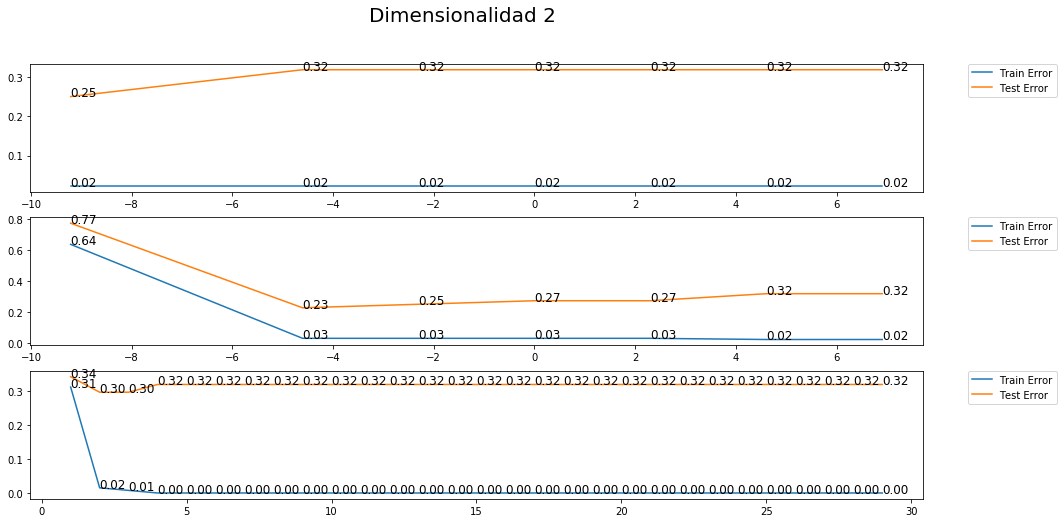

(0.25, 0.22727272727272729, 0.29545454545454541)

In [28]:
get_results_for_lda_dimensionality(2)

Se tiene un *warning* en el código debido a que las variables son colineares, es decir, que existe dependencia lineal entre ellas. Debido a la naturaleza de LDA en donde se computan matrices inverzas, un determinante igual a 0 puede hacer dicho calculo altamente impreciso.

La proyección obtenida con LDA corresponde a:

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


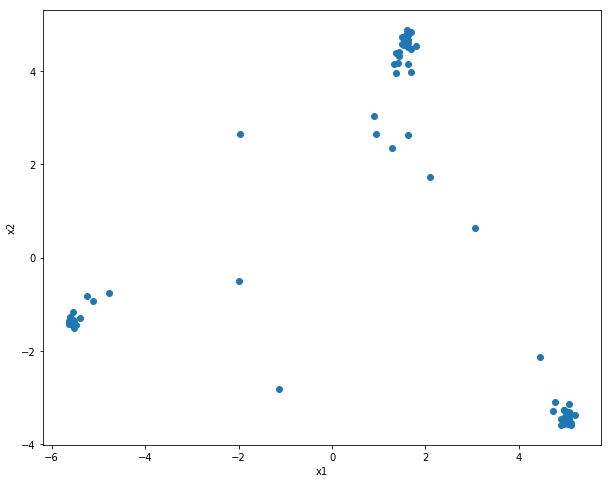

In [29]:
model_lda = LDA(n_components=2)
model_lda.fit(X_train,y_train)
X_pca_train = model_lda.transform(X_train)
X_pca_test = model_lda.transform(X_test)
x1 = np.array(X_pca_train)[:,0]
x2 = np.array(X_pca_train)[:,1]
plt.figure(figsize=(10, 8))
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(x1, x2)
plt.show()

Se utilizan distintos valores de dimensionalidad para obtener el siguiente gráfico y compararlo con PCA

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


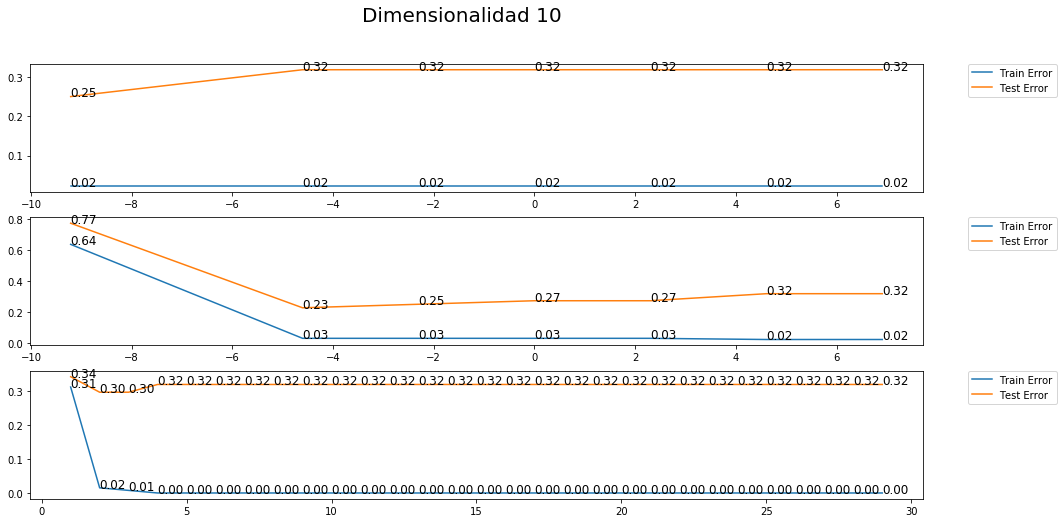

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


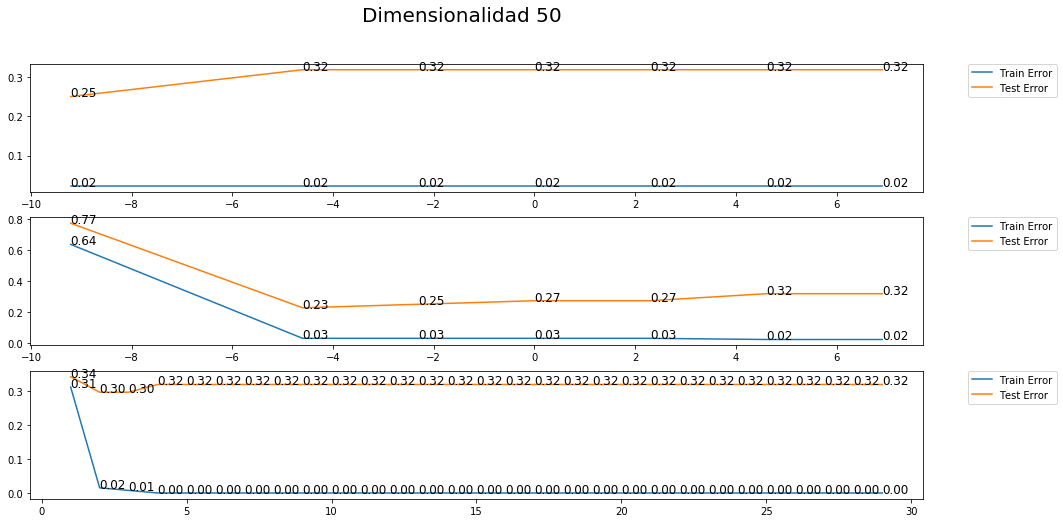

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


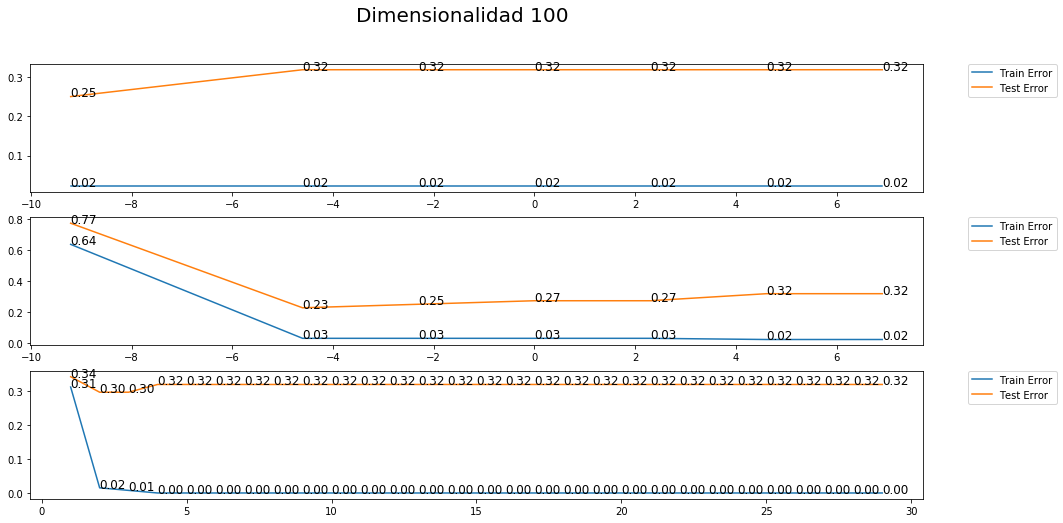

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


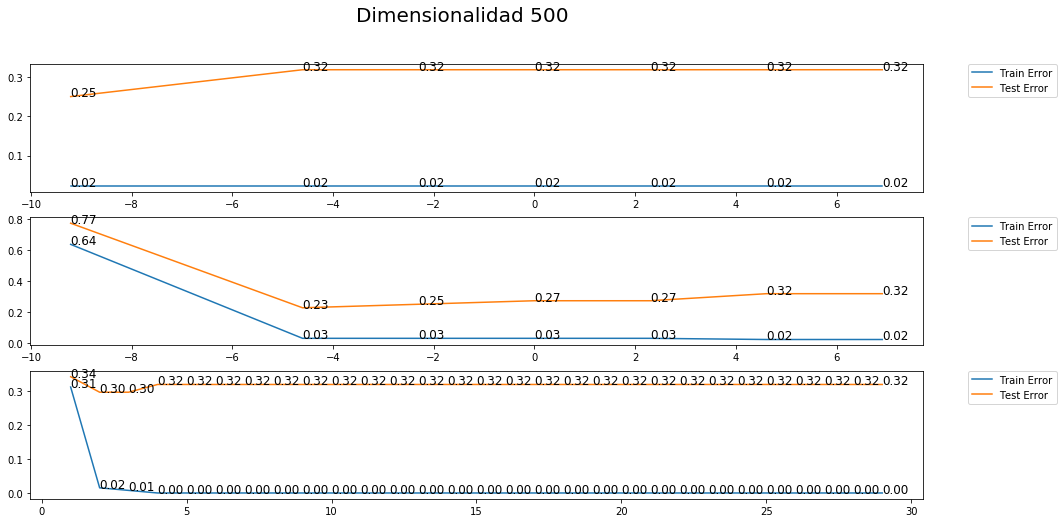

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


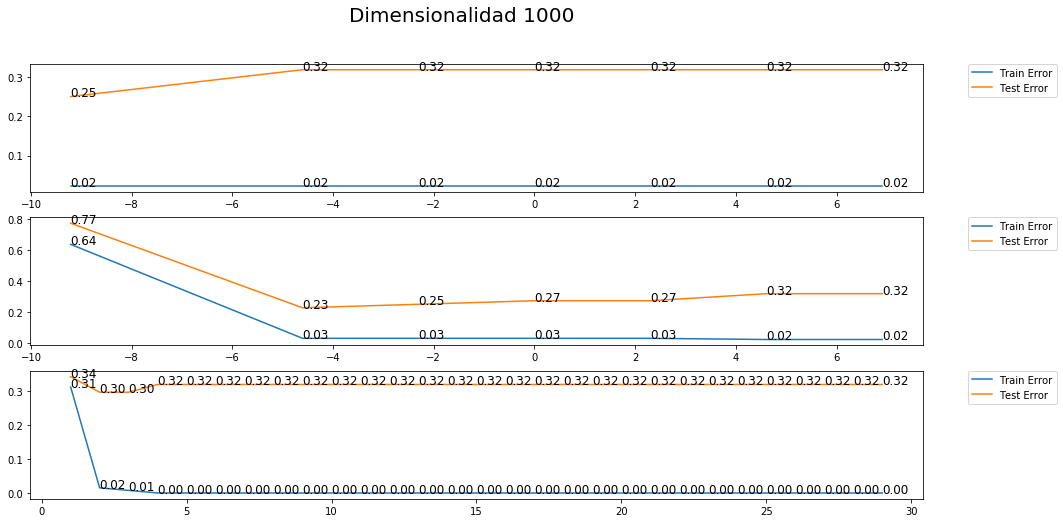

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


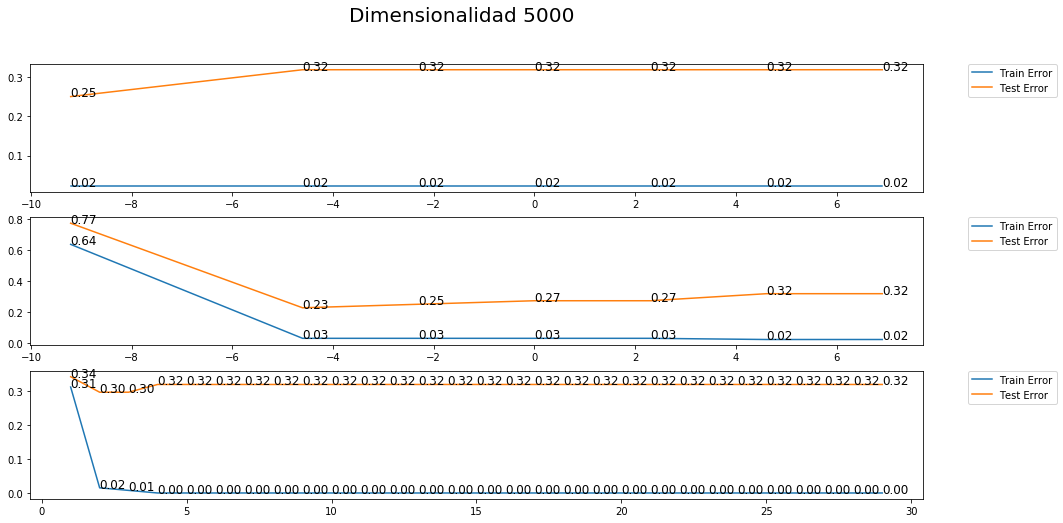

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


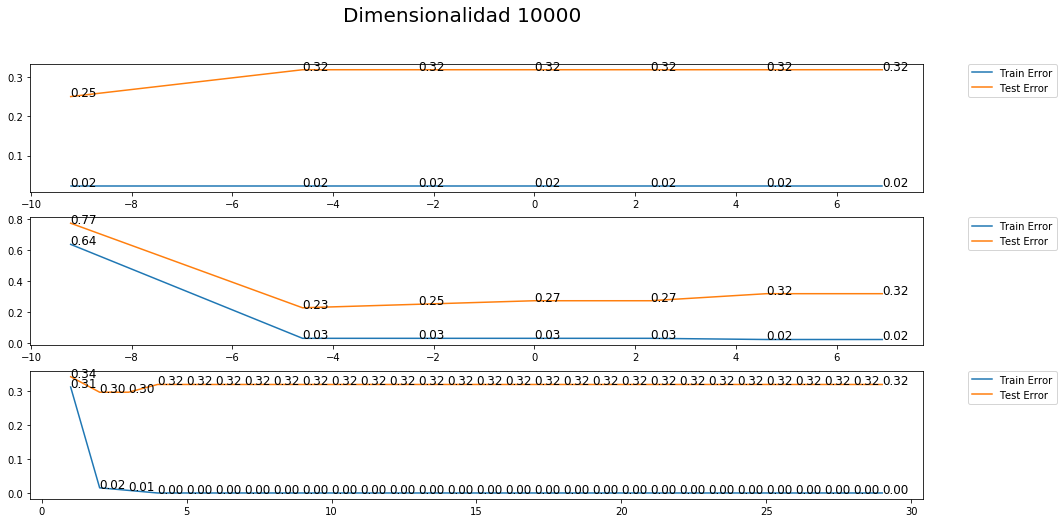

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


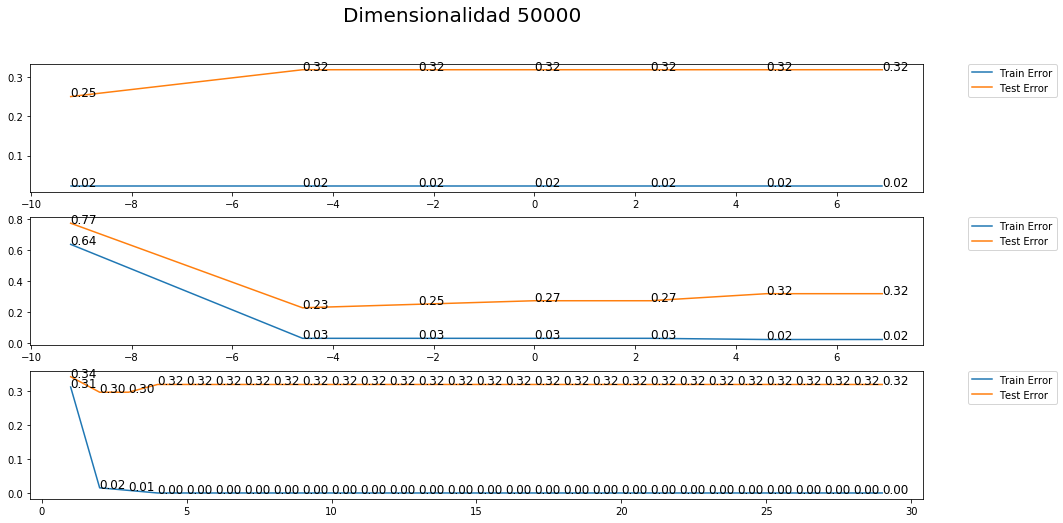

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


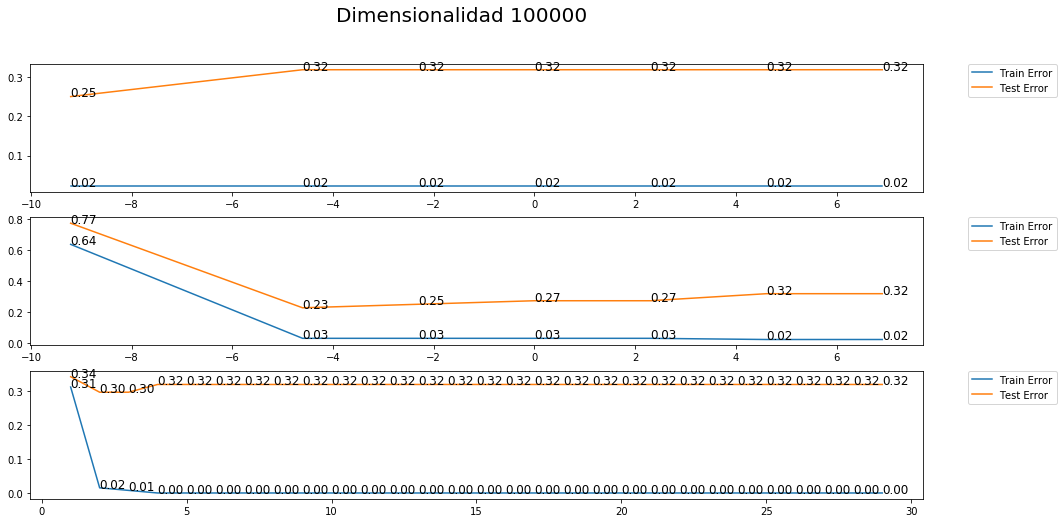

In [30]:
lda_log_min_test_error = []
lda_svm_min_test_error = []
lda_tree_min_test_error = []
for d in dims:
    (log_min, svm_min, tree_min) = get_results_for_lda_dimensionality(d)
    lda_log_min_test_error.append(log_min)
    lda_svm_min_test_error.append(svm_min)
    lda_tree_min_test_error.append(tree_min)

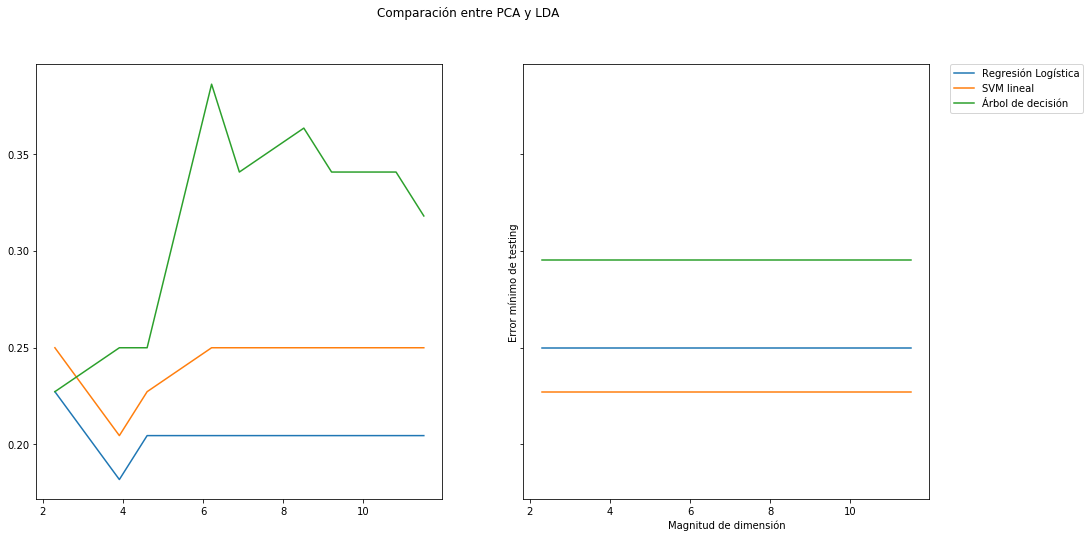

In [31]:
f, [ax1, ax2] = plt.subplots(1, 2, sharex=True, sharey=True)


f.suptitle('Comparación entre PCA y LDA')
f.set_size_inches(16, 8)
f.add_axes()
ax1.plot(np.log(dims), pca_log_min_test_error, label="Regresión Logística")
ax1.plot(np.log(dims), pca_svm_min_test_error, label="SVM lineal")
ax1.plot(np.log(dims), pca_tree_min_test_error, label="Árbol de decisión")

plt.xlabel("Magnitud de dimensión")
plt.ylabel("Error mínimo de testing")

#ax2.figure(figsize=(10, 8), suptitle="LDA")
ax2.plot(np.log(dims), lda_log_min_test_error, label="Regresión Logística")
ax2.plot(np.log(dims), lda_svm_min_test_error, label="SVM lineal")
ax2.plot(np.log(dims), lda_tree_min_test_error, label="Árbol de decisión")
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel("Magnitud de dimensión")
plt.ylabel("Error mínimo de testing")


plt.show()

Analizando los gráficos anteriores se puede observar que es a través de reducción de dimensionalidad utilizando **PCA** que se puede obtener el menor error de entrenamiento posible, o dicho de otro modo, la mejor precisión en la clasificación.

Analizando los mejores resultados para PCA:

In [32]:
print("Dimensionalidad", dims[np.argmin(pca_log_min_test_error)])

Dimensionalidad 50


Se tiene que la dimensionalidad óptima es de 50. Además, volviendo a los gráficos anteriores se tiene que el mejor parámetro para regresión logística es $C = 10^{-3}$ obteniendose un error de testing aproximado de $0.18$ que equivale a una precisión del 82%

## Otras alternativas para el desempeño

En lugar de trabajar los archivos de audio directamente como series de tiempo transformadas con series de Fourier, es también factible utilizar metricas de los archivos de audio, como promedio de serie de tiempo, frecuencia, entre otros atributos. A continuación se calculan dichas métricas:

In [33]:
import pandas as pd
import numpy as np
import scipy
from collections import Counter
columns = [
    'meanfreq',
    'sd',
    'median',
    'Q25',
    'Q50',
    'Q75',
    'IQR',
    'skew',
    'kurt',
    'mode',
    'meanfun',
    'meandom',
    'maxdom',
    'dfrange',
    'modindix',
]

pd.DataFrame(columns=columns)

# Perform standarization
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_train)
X_custom_train = std.transform(X_train)
X_custom_test = std.transform(X_test)


# Ge metrics
def get_metrics(x):
    meanfreq = np.mean(x)
    sd = np.std(x)
    median = np.median(x)
    Q25 = np.percentile(x, 25)
    Q50 = np.percentile(x, 50)
    Q75 = np.percentile(x, 75)
    IQR = iqr = np.subtract(*np.percentile(x, [75, 25]))
    skew = scipy.stats.skew(x)
    kurt = scipy.stats.kurtosis(x)
    minimum = np.min(x)
    maximum = np.max(x)
    data = Counter(x)
    mode = data.most_common(1)[0][0]
    
    return  [meanfreq, sd, median, Q25, Q50, Q75, IQR, skew, kurt, minimum, maximum, mode]
    

X_new_train = list(map(get_metrics, X_custom_train))
X_new_test = list(map(get_metrics, X_custom_test))


Utilizando regresión logística, se tiene entonces:

Training logistic
Training SVM
Training Tree


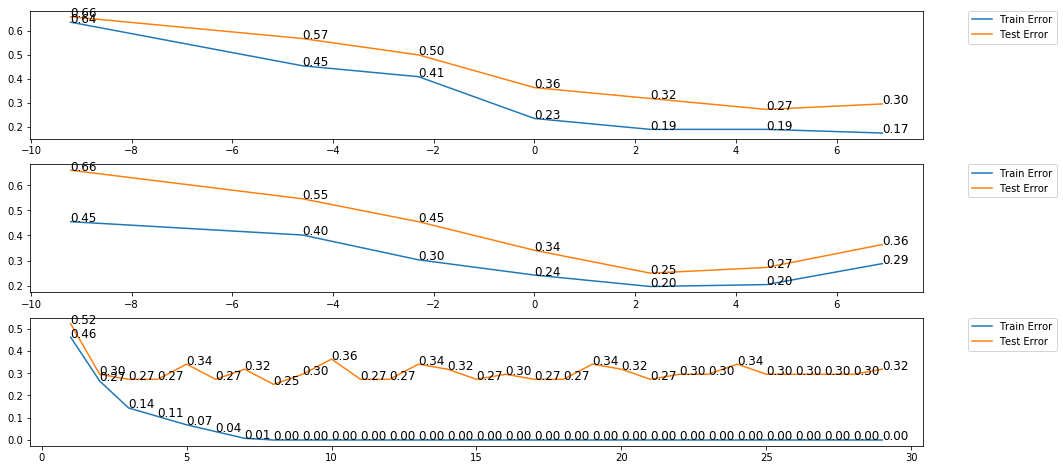

(0.27272727272727271, 0.25, 0.25)

In [34]:
def get_results_for_custom():
    f, [ax1, ax2, ax3] = plt.subplots(3)
    f.set_size_inches(16, 8)

    print('Training logistic')
    (train, test) = train_logistic(X_new_train, y_train, X_new_test, y_test, Cs)
    plot_logistic(train, test, fig=ax1, verbose=False)
    log_min_error = np.amin(test)

    print('Training SVM')
    (train, test) = train_svm(X_new_train, y_train, X_new_test, y_test, Cs)
    plot_svm(train, test, fig=ax2, verbose=False)
    svm_min_error = np.amin(test)

    print('Training Tree')
    (train, test) = train_tree(X_new_train, y_train, X_new_test, y_test, Depths)
    plot_tree(train, test, fig=ax3, verbose=False)
    tree_min_error = np.amin(test)
    plt.show()
    return (log_min_error, svm_min_error, tree_min_error)
get_results_for_custom()

Lo cual no logra mejorar el valor de 0.18 obtenido anteriormenteu sando PCA y regresión logística. Esto es esperable considerando que las metricas pueden llevar a una perdida de información acerca del comportamiendo de los datos de los archivos de entrada. Con un conjunto adicional y significativo de metricas se podría llegar a reducir el error de clasificación